In [1]:
# Import libraries
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

# set plot size
plt.rcParams["figure.figsize"] = (20, 13)

%matplotlib inline
%config InlineBackend.figure_format = "retina"


/Users/alexisletrung/perso/epita/FinalProject_2025_Alexis.LE-TRUNG/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## Load the data


In [62]:
interactions_train = pd.read_csv("./KuaiRec 2.0/data/big_matrix.csv")
interactions_train.head()



,user_id,video_id,play_duration,video_duration,time,date,timestamp,watch_ratio
0,0,3649,13838,10867,2020-07-05 00:08:23.438,20200705,1.593879e+09,1.273397
1,0,9598,13665,10984,2020-07-05 00:13:41.297,20200705,1.593879e+09,1.244082
2,0,5262,851,7908,2020-07-05 00:16:06.687,20200705,1.593879e+09,0.107613
3,0,1963,862,9590,2020-07-05 00:20:26.792,20200705,1.593880e+09,0.089885
4,0,8234,858,11000,2020-07-05 00:43:05.128,20200705,1.593881e+09,0.078000


In [63]:
interactions_test = pd.read_csv("./KuaiRec 2.0/data/small_matrix.csv")
interactions_test.head()


,user_id,video_id,play_duration,video_duration,time,date,timestamp,watch_ratio
0,14,148,4381,6067,2020-07-05 05:27:48.378,20200705.0,1.593898e+09,0.722103
1,14,183,11635,6100,2020-07-05 05:28:00.057,20200705.0,1.593898e+09,1.907377
2,14,3649,22422,10867,2020-07-05 05:29:09.479,20200705.0,1.593898e+09,2.063311
3,14,5262,4479,7908,2020-07-05 05:30:43.285,20200705.0,1.593898e+09,0.566388
4,14,8234,4602,11000,2020-07-05 05:35:43.459,20200705.0,1.593899e+09,0.418364


# Data Analysis

# Check for missing/error values

In [ ]:
print(f"=== Check for nan in train ===")
for column in interactions_train.columns:
    if not interactions_train[interactions_train[column].isna()].empty:
        print(f"Column: {column}")

print(f"=== Check for nan in test ===")
for column in interactions_test.columns:
    if not interactions_test[interactions_test[column].isna()].empty:
        print(f"Column: {column}")

print(f"=== Check for negative values in train ===")
for column in ['play_duration','video_duration','watch_ratio']:
    if not interactions_train[interactions_train[column] < 0].empty:
        print(f"Column: {column}")

print(f"=== Check for negative values in test ===")
for column in ['play_duration','video_duration','watch_ratio']:
    if not interactions_test[interactions_test[column] < 0].empty:
        print(f"Column: {column}")




In [89]:
def check_impossible_values(df, columns):
    for col in columns:
        print(f"\nVérification de la colonne {col}:")
        if col == "time":
            is_str = df[col].apply(lambda x: isinstance(x, str))
            is_dt = pd.to_datetime(df[col], errors='coerce').notna()
            mask_valid = is_str & is_dt
        elif col == "date":
            # Tenter conversion en entier puis en string et vérifier les 8 chiffres
            val = pd.to_numeric(df[col], errors='coerce').dropna()
            str_val = val.astype('int64').astype(str)
            mask_valid = df[col].notna() & str_val.str.match(r"^\d{8}$")
            # Remettre l'index sur df pour éviter le bug
            mask_valid = mask_valid.reindex(df.index, fill_value=False)
        elif col == "timestamp":
            val = pd.to_numeric(df[col], errors='coerce')
            mask_valid = val.notna() & (val > 1e9)
        else:
            continue

        invalid = df[~mask_valid]
        print(f"{len(invalid)} valeurs impossibles dans '{col}'")
        if not invalid.empty:
            print(invalid[[col]].head())



print("=== Vérification des valeurs impossibles dans interactions_train ===")
check_impossible_values(interactions_train, ['time', 'date', 'timestamp'])

print("\n=== Vérification des valeurs impossibles dans interactions_test ===")
check_impossible_values(interactions_test, ['time', 'date', 'timestamp'])

=== Vérification des valeurs impossibles dans interactions_train ===

Vérification de la colonne time:
0 valeurs impossibles dans 'time'

Vérification de la colonne date:
0 valeurs impossibles dans 'date'

Vérification de la colonne timestamp:
0 valeurs impossibles dans 'timestamp'

=== Vérification des valeurs impossibles dans interactions_test ===

Vérification de la colonne time:
181992 valeurs impossibles dans 'time'
     time
3234  NaN
3235  NaN
3236  NaN
3237  NaN
3238  NaN

Vérification de la colonne date:
181992 valeurs impossibles dans 'date'
      date
3234   NaN
3235   NaN
3236   NaN
3237   NaN
3238   NaN

Vérification de la colonne timestamp:
181992 valeurs impossibles dans 'timestamp'
      timestamp
3234        NaN
3235        NaN
3236        NaN
3237        NaN
3238        NaN


In [90]:
print(f"=== Ratio de nan dans test sur time/date/timestamp ===")
for column in ['time', 'date', 'timestamp']:
    ratio = interactions_test[column].isna().sum() / len(interactions_test)
    print(f"Column: {column} - Ratio: {ratio:.2%}")

=== Ratio de nan dans test sur time/date/timestamp ===
Column: time - Ratio: 3.89%
Column: date - Ratio: 3.89%
Column: timestamp - Ratio: 3.89%


 Commentaire sur les nan ?
 

Regardons si il y a des doublons d'interactions.


=== Ratio de doublons dans train ===
Ratio des doublons: 0.8220515902967455
Nombre des doublons: 10300969
=== Ratio de doublons dans test ===
Ratio des doublons: 1.0
Nombre des doublons: 4676570


In [65]:
interactions_train['video_duration'] =interactions_train['video_duration'] / 1000
interactions_train['play_duration'] = interactions_train['play_duration'] / 1000
interactions_test['play_duration'] = interactions_train['play_duration'] / 1000
interactions_test['video_duration'] = interactions_test['video_duration'] / 1000

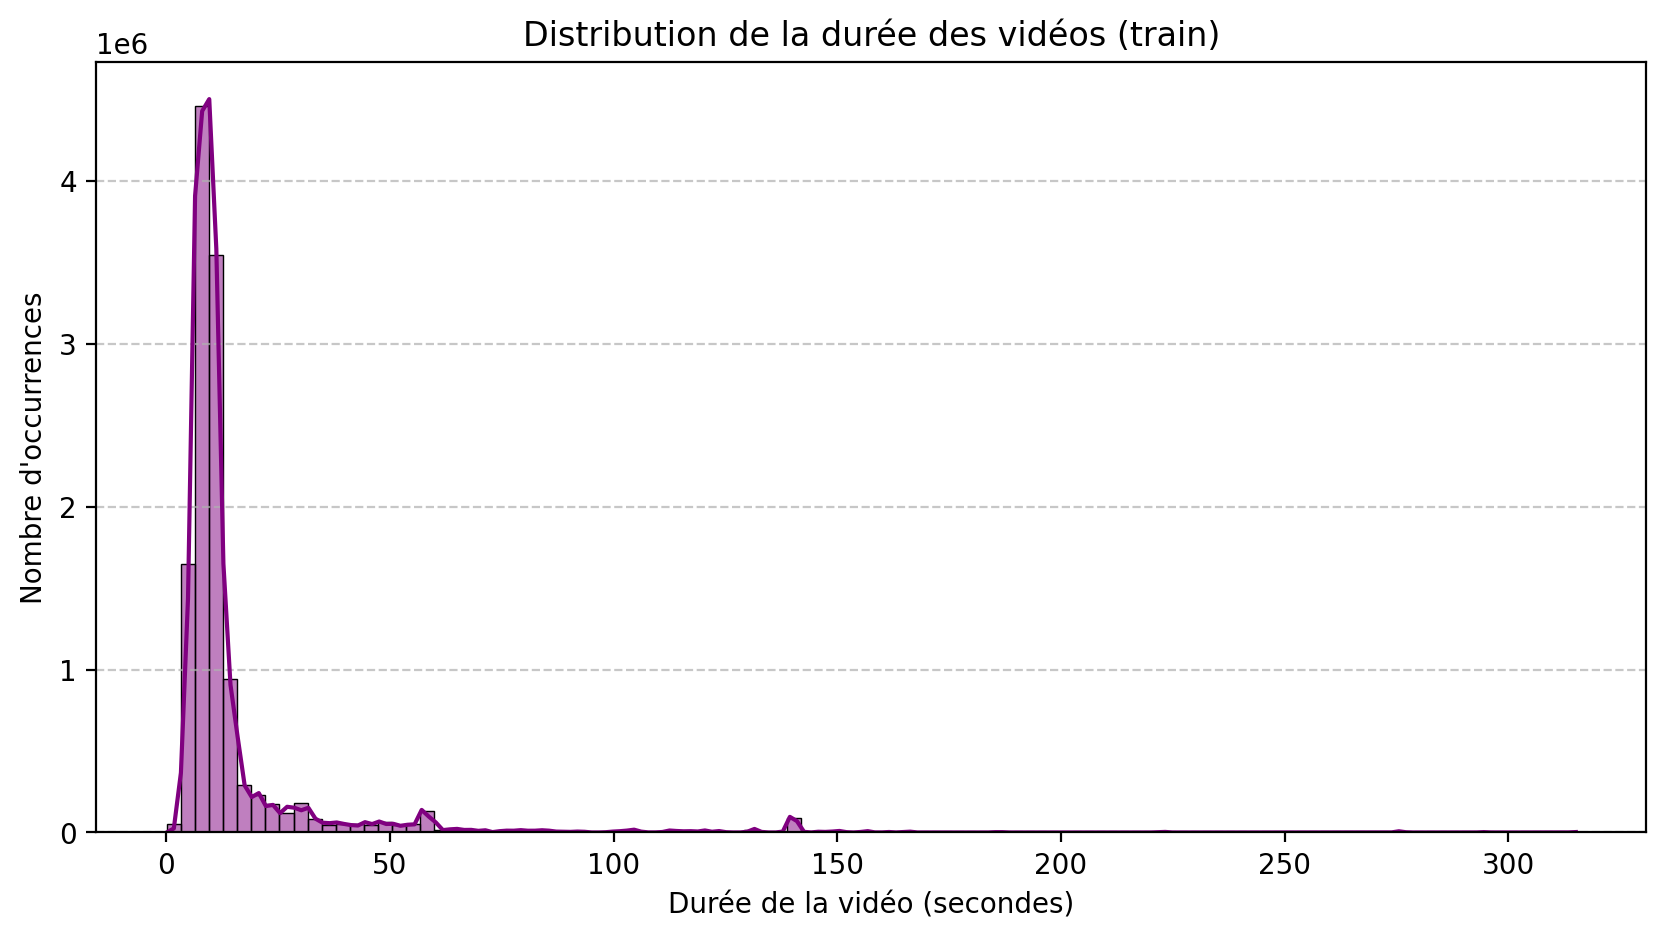

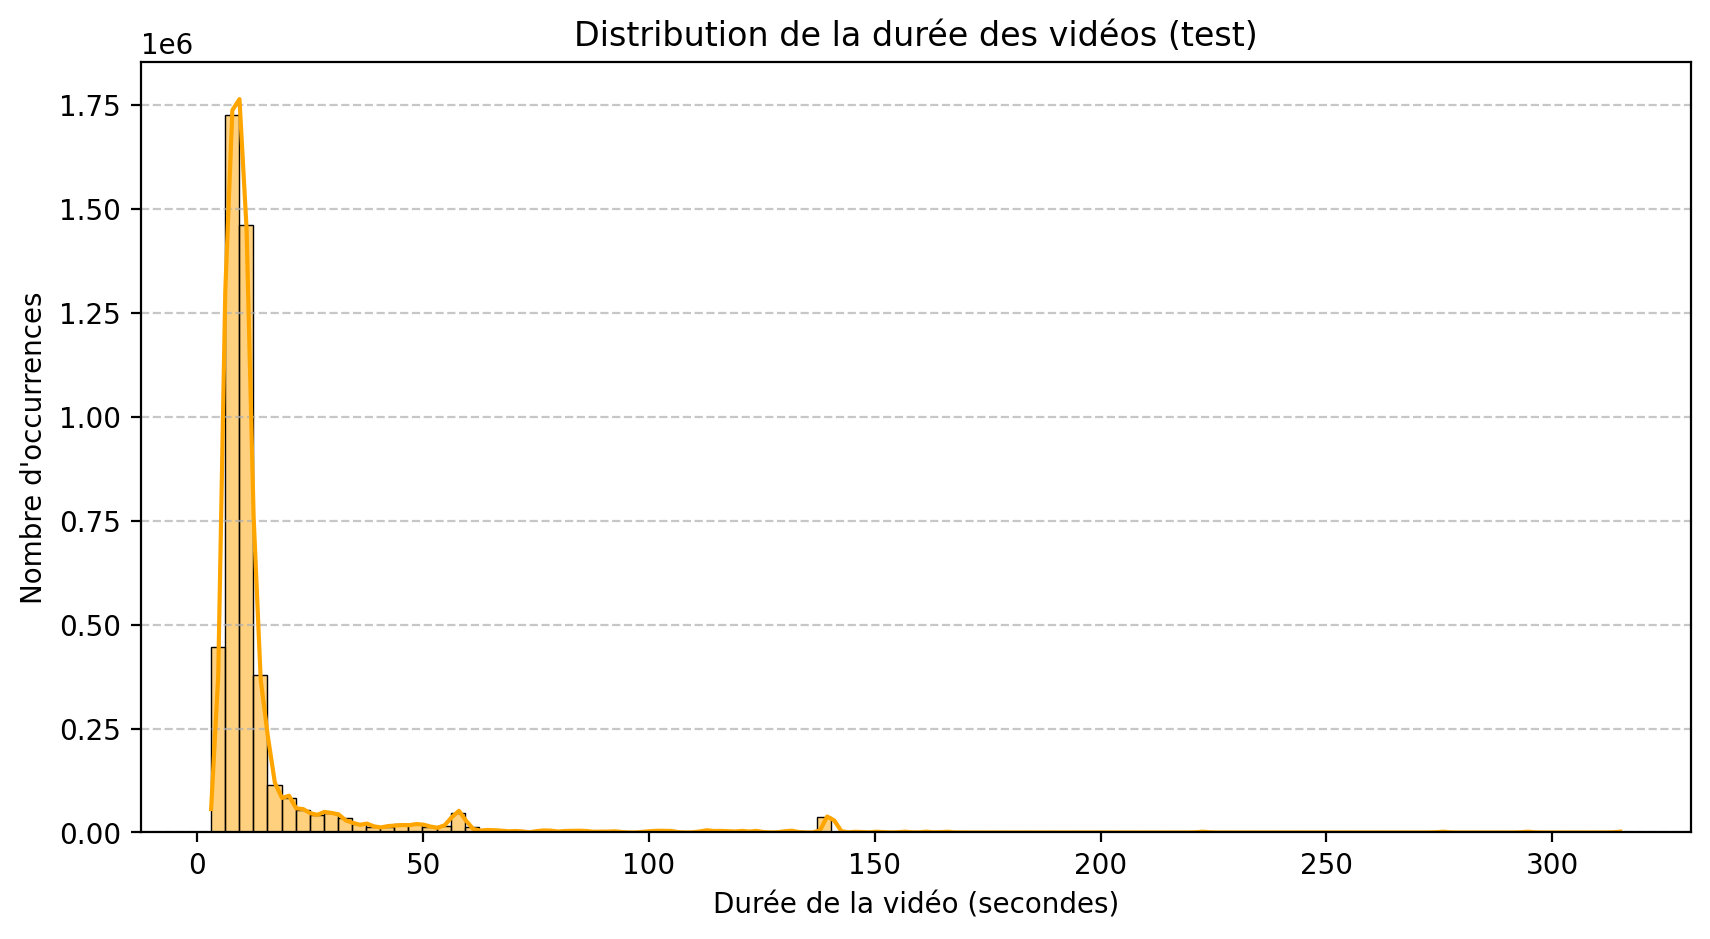

In [66]:
# Afficher la distribution de la durée des vidéos dans le train
plt.figure(figsize=(10, 5))
sns.histplot(interactions_train['video_duration'], bins=100, kde=True, color='purple')
plt.title("Distribution de la durée des vidéos (train)")
plt.xlabel("Durée de la vidéo (secondes)")
plt.ylabel("Nombre d'occurrences")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Afficher la distribution de la durée des vidéos dans le test
plt.figure(figsize=(10, 5))
sns.histplot(interactions_test['video_duration'], bins=100, kde=True, color='orange')
plt.title("Distribution de la durée des vidéos (test)")
plt.xlabel("Durée de la vidéo (secondes)")
plt.ylabel("Nombre d'occurrences")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [39]:
# Statistiques descriptives sur la durée des vidéos dans le train
print("=== Statistiques sur la durée des vidéos (train) ===")
print(interactions_train['video_duration'].describe())

# Statistiques descriptives sur la durée des vidéos dans le test
print("\n=== Statistiques sur la durée des vidéos (test) ===")
print(interactions_test['video_duration'].describe())

=== Statistiques sur la durée des vidéos (train) ===
count    1.253081e+07
mean     1.462157e+01
std      1.983474e+01
min      1.400000e-01
25%      7.434000e+00
50%      9.636000e+00
75%      1.217900e+01
max      3.150720e+02
Name: video_duration, dtype: float64

=== Statistiques sur la durée des vidéos (test) ===
count    4.676570e+06
mean     1.448645e+01
std      2.046711e+01
min      3.067000e+00
25%      7.523000e+00
50%      9.600000e+00
75%      1.193400e+01
max      3.150720e+02
Name: video_duration, dtype: float64


Nous allons voir si il existe des doublons de pair user/video.


In [ ]:
dups_train = interactions_train.groupby(['user_id', 'video_id']).size().reset_index(name='count')

print(f"=== Ratio de doublons dans train ===")
print(f"Ratio des doublons: {len(dups_train) / len(interactions_train)}")
print(f"Nombre des doublons: {len(dups_train)}")

dups_test = interactions_test.groupby(['user_id', 'video_id']).size().reset_index(name='count')
print(f"=== Ratio de doublons dans test ===")
print(f"Ratio des doublons: {len(dups_test) / len(interactions_test)}")
print(f"Nombre des doublons: {len(dups_test)}")

Ratio of duplicates: 0.8220515902967455
Number of duplicates: 10300969
Ratio of duplicates: 1.0
Number of duplicates: 4676570


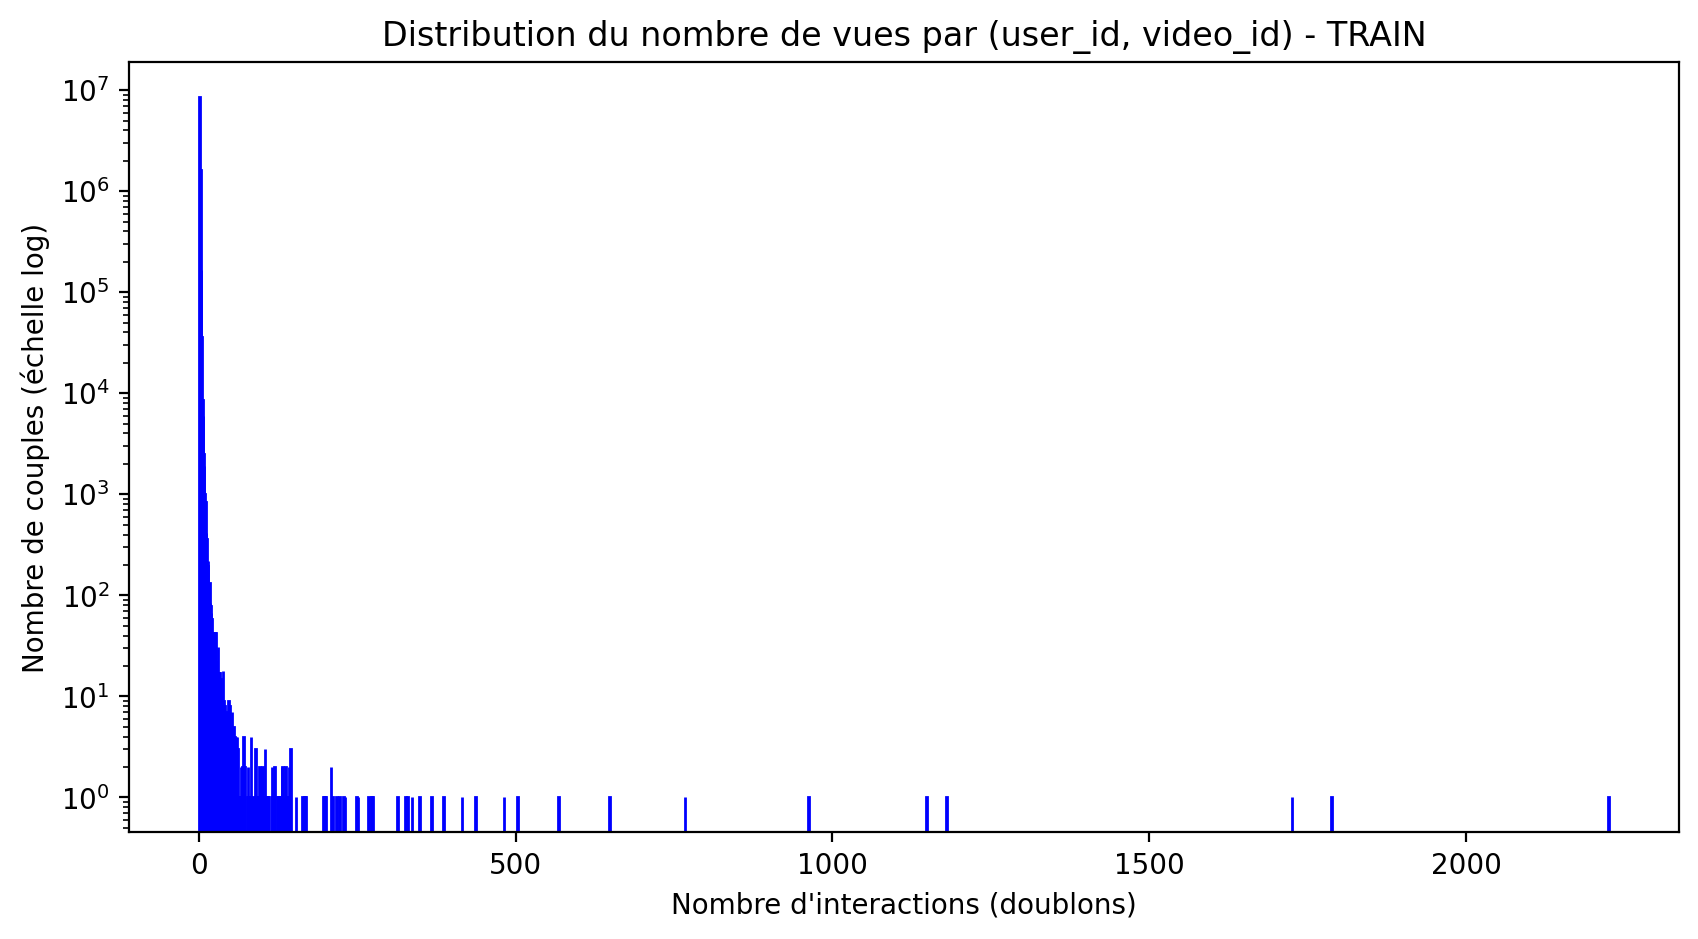

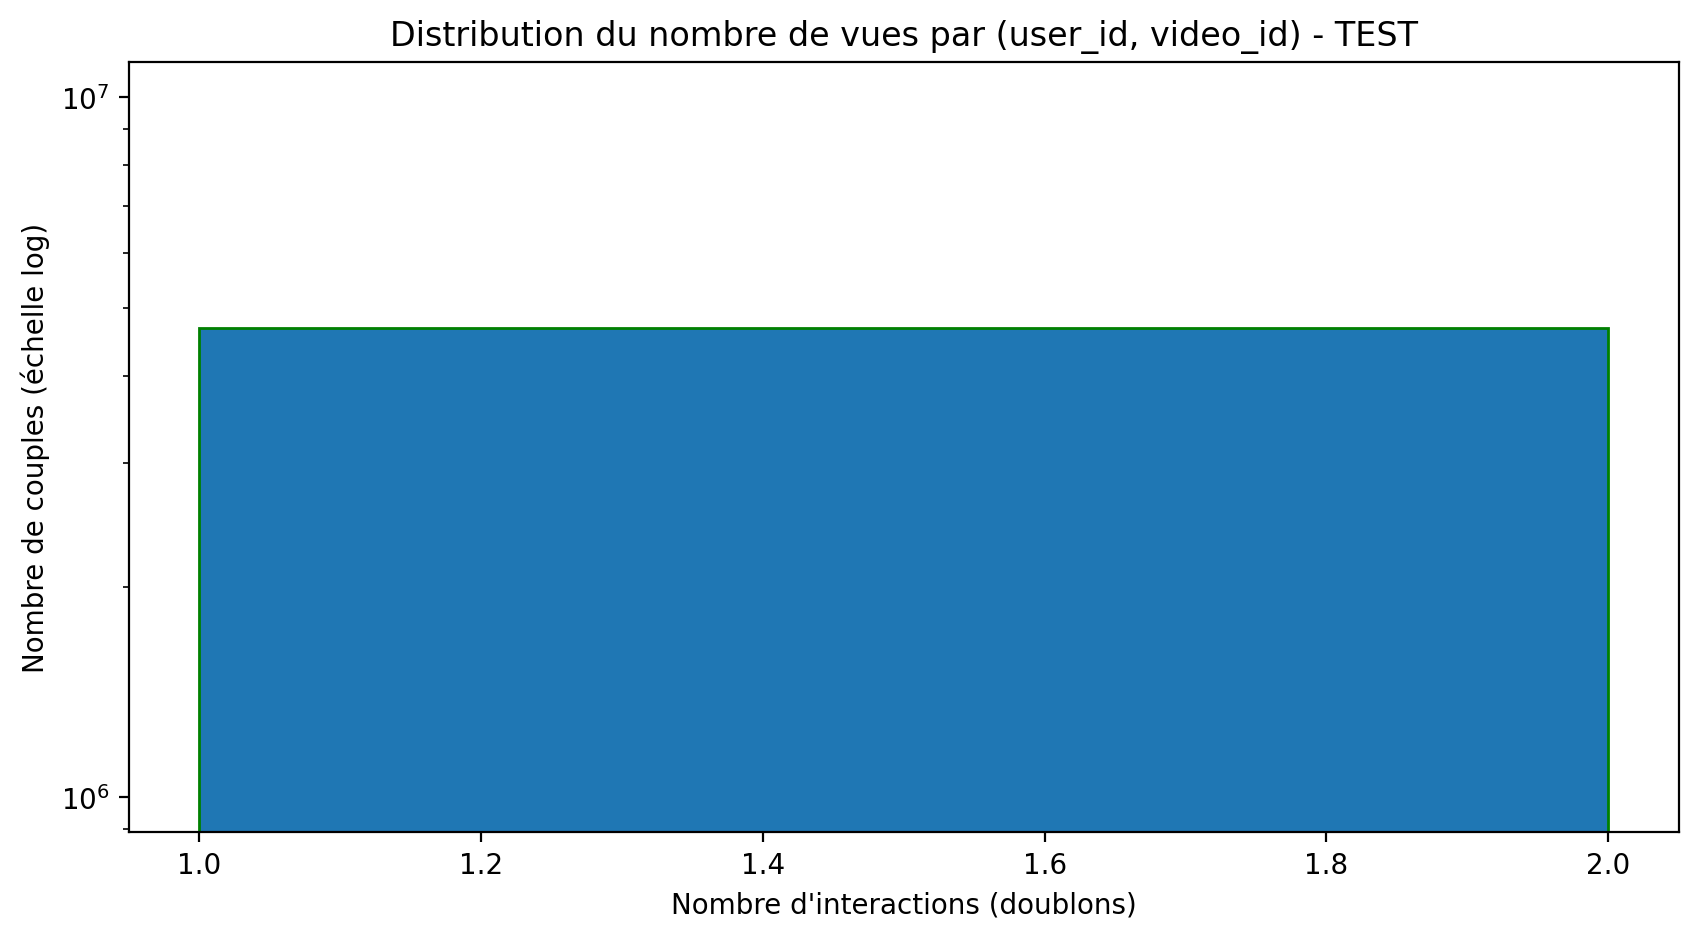

In [6]:
# Visualiser la distribution des doublons dans le train
plt.figure(figsize=(10, 5))
plt.hist(dups_train['count'], bins=range(1, dups_train['count'].max() + 2), edgecolor='blue', log=True)
plt.title("Distribution du nombre de vues par (user_id, video_id) - TRAIN")
plt.xlabel("Nombre d'interactions (doublons)")
plt.ylabel("Nombre de couples (échelle log)")
plt.grid(False)
plt.show()

# Visualiser la distribution des doublons dans le test
plt.figure(figsize=(10, 5))
plt.hist(dups_test['count'], bins=range(1, dups_test['count'].max() + 2), edgecolor='green', log=True)
plt.title("Distribution du nombre de vues par (user_id, video_id) - TEST")
plt.xlabel("Nombre d'interactions (doublons)")
plt.ylabel("Nombre de couples (échelle log)")
plt.grid(False)
plt.show()

Cette information est importante, je vais considerer que le watch_ratio sera la somme des doublons.


In [82]:
# Garder uniquement les doublons (count > 1)
dups = dups_train[dups_train['count'] > 1][['user_id', 'video_id']]

# Calculer la différence max-min de video_duration pour chaque doublon
duration_diff = (
    interactions_train
    .merge(dups, on=['user_id', 'video_id'])
    .groupby(['user_id', 'video_id'])['video_duration']
    .agg(['min', 'max'])
    .reset_index()
)
duration_diff['diff'] = duration_diff['max'] - duration_diff['min']

# Garder uniquement les cas où la différence dépasse 1 seconde
diff_gt_1s = duration_diff[duration_diff['diff'] > 0.0]

# Afficher les résultats
print(diff_gt_1s)

         user_id  video_id      min      max   diff
84             0      2917   12.667   12.688  0.021
125            0      4307   11.384   11.434  0.050
147            0      5291    6.711    6.767  0.056
170            0      5944    8.940    9.000  0.060
247            0      8922    7.360    7.434  0.074
...          ...       ...      ...      ...    ...
1840009     7169      9933    5.267    5.334  0.067
1840058     7170       774   10.837   10.841  0.004
1840119     7170      3686   10.450   10.500  0.050
1840147     7170      4636  315.040  315.056  0.016
1840696     7172      7031    9.250    9.257  0.007

[33014 rows x 5 columns]


In [83]:
# Afficher toutes les lignes du DataFrame interactions_train correspondant à un doublon précis
# Exemple : pour le premier doublon trouvé dans dups_train
def display_duplicate_rows(user_id, video_id):
    duplicate_rows = interactions_train[(interactions_train['user_id'] == user_id) & (interactions_train['video_id'] == video_id)]
    return duplicate_rows

display_duplicate_rows(0, 2917)

,user_id,video_id,play_duration,video_duration,time,date,timestamp,watch_ratio
1434,0,2917,14.217,12.667,2020-08-08 10:22:46.838,20200808,1.596853e+09,1.122365
1824,0,2917,0.787,12.688,2020-08-27 08:49:15.467,20200827,1.598489e+09,0.062027


In [41]:
interactions_train_filtered = interactions_train.groupby(['user_id', 'video_id'], as_index=False)['watch_ratio'].sum()
interactions_test_filtered = interactions_test.groupby(['user_id', 'video_id'], as_index=False)['watch_ratio'].sum()





Max watch_ratio: 6574.981596339603
Min watch_ratio: 0.0


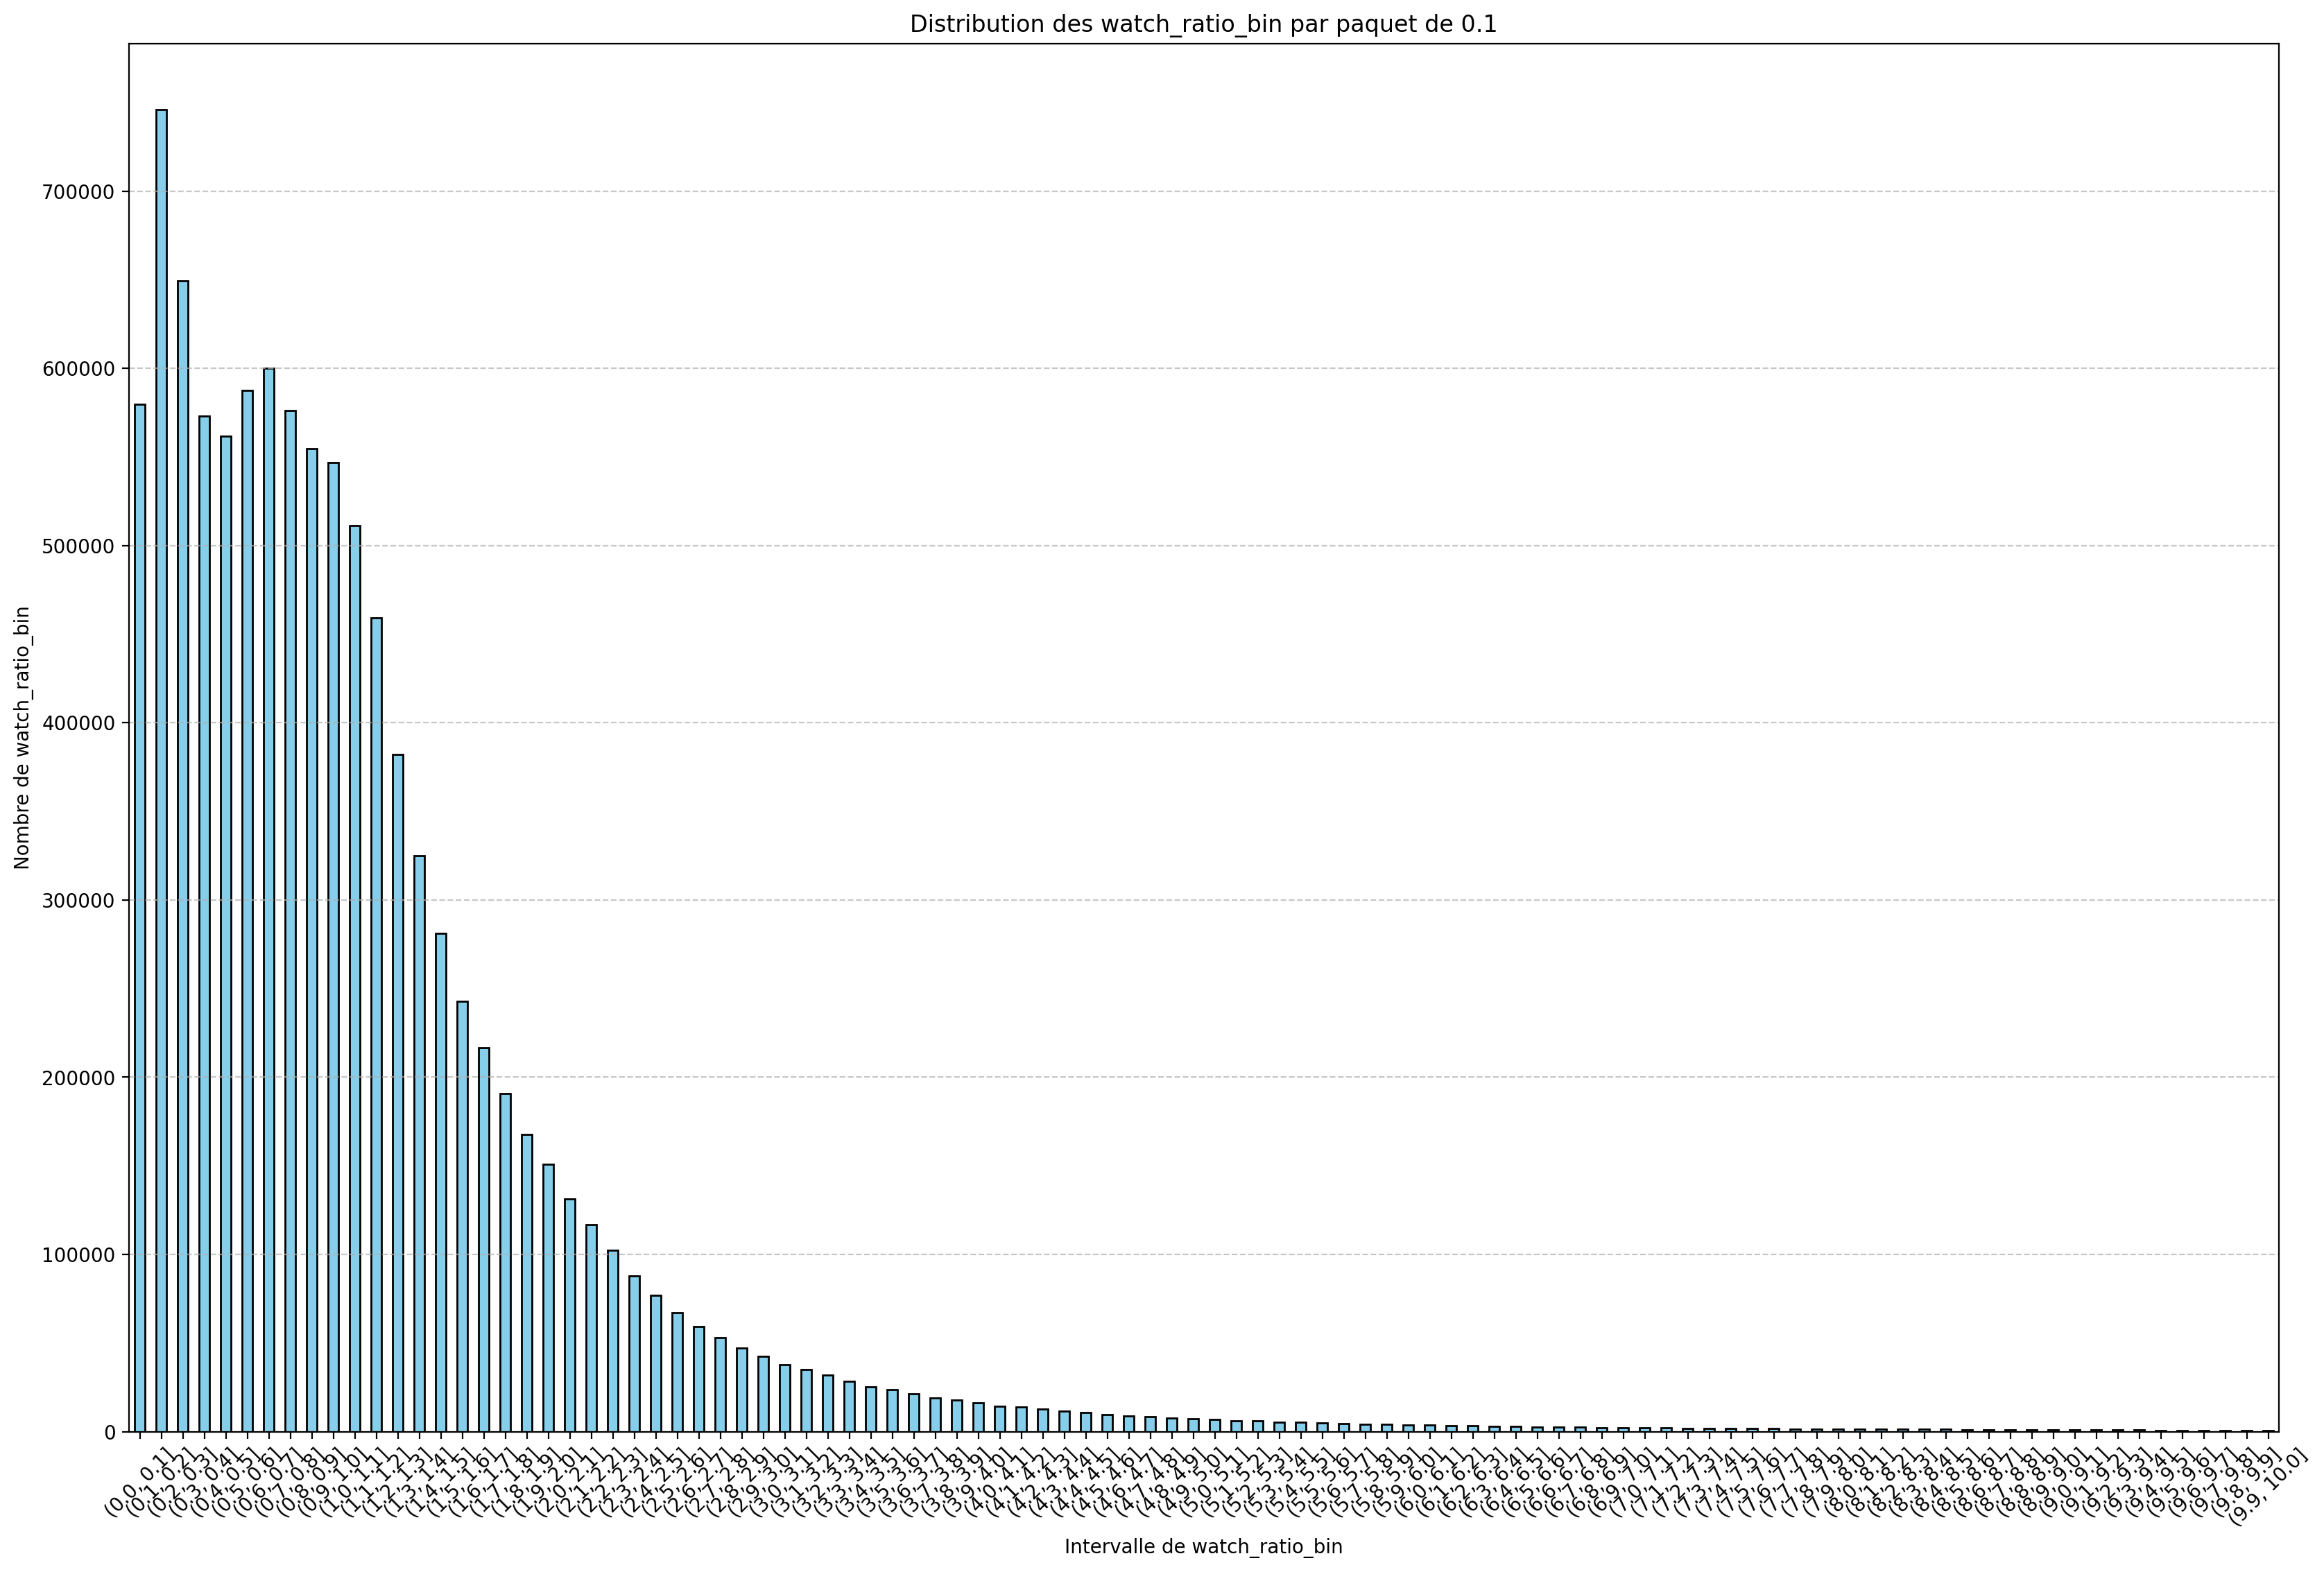

In [8]:

interactions_train_filtered['watch_ratio_bin'] = pd.cut(interactions_train_filtered['watch_ratio'], bins=np.arange(0, 10.1, 0.1))
print(f"Max watch_ratio: {interactions_train_filtered['watch_ratio'].max()}")
print(f"Min watch_ratio: {interactions_train_filtered['watch_ratio'].min()}")

# Compter le nombre de prédictions dans chaque intervalle
bin_counts = interactions_train_filtered['watch_ratio_bin'].value_counts().sort_index()

# Tracer l'histogramme
bin_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Distribution des watch_ratio_bin par paquet de 0.1")
plt.xlabel("Intervalle de watch_ratio_bin")
plt.ylabel("Nombre de watch_ratio_bin")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Max watch_ratio: 571.5214280603849
Min watch_ratio: 0.0


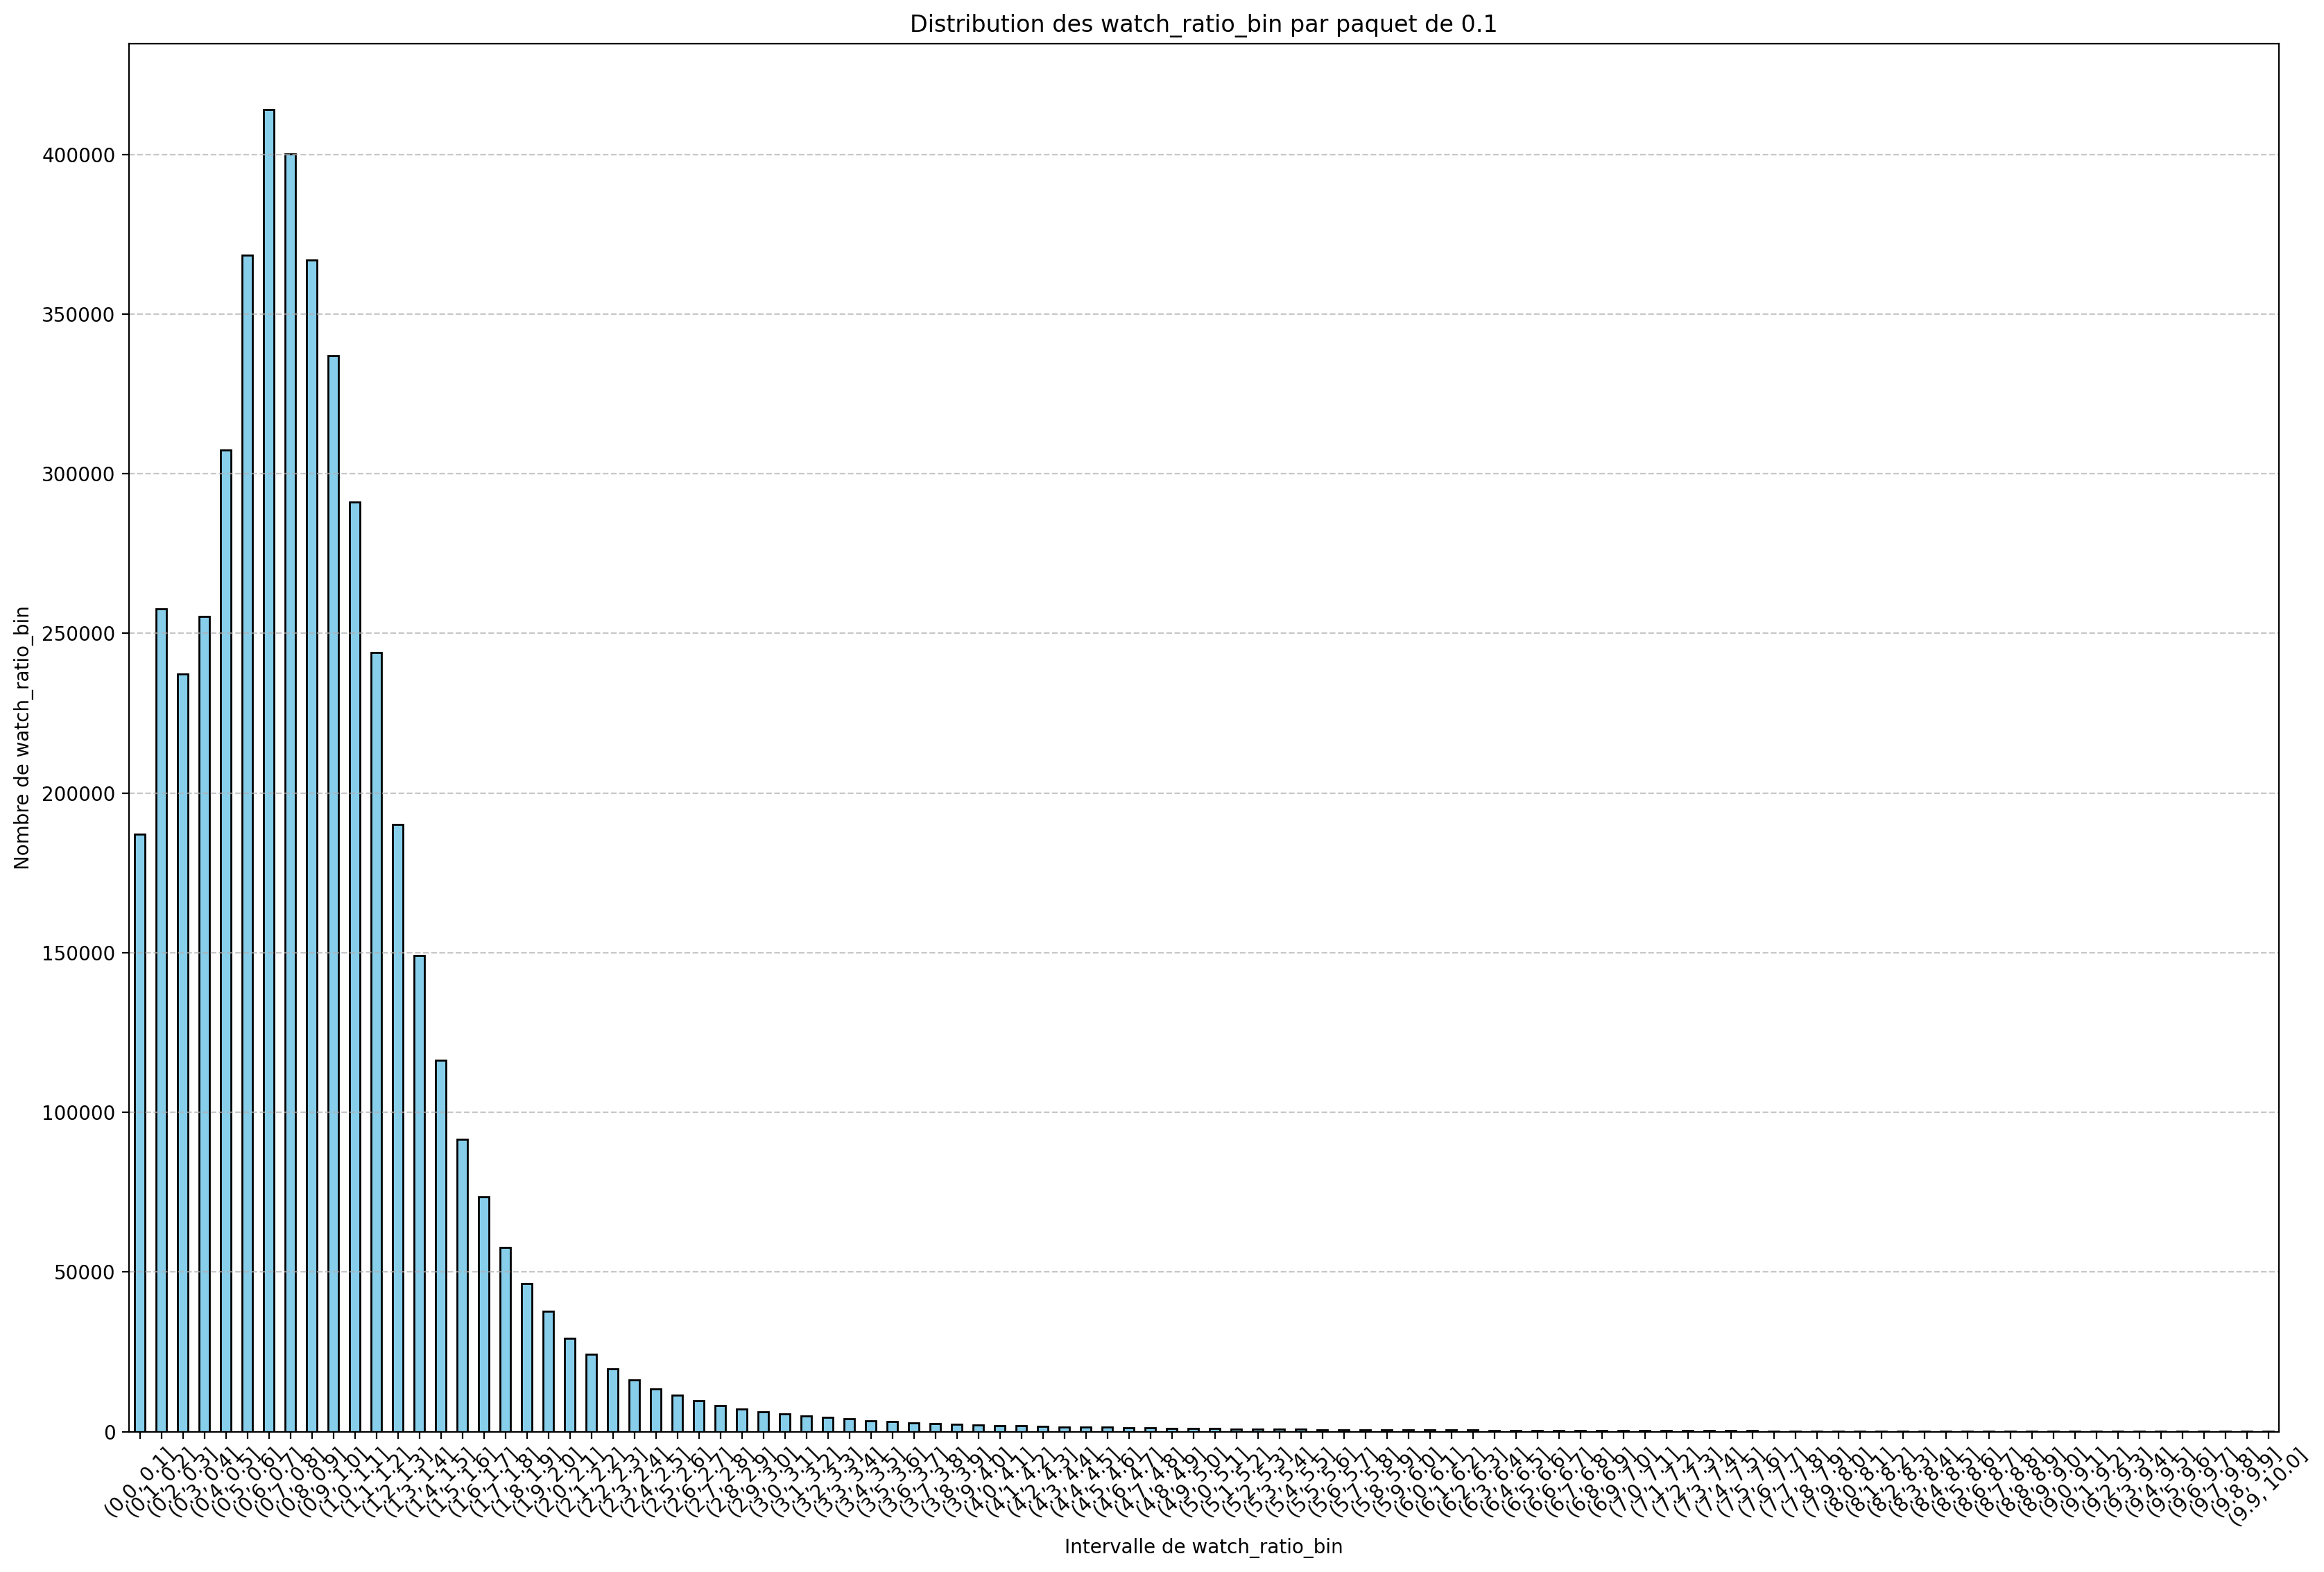

In [9]:

interactions_test_filtered['watch_ratio_bin'] = pd.cut(interactions_test_filtered['watch_ratio'], bins=np.arange(0, 10.1, 0.1))
print(f"Max watch_ratio: {interactions_test_filtered['watch_ratio'].max()}")
print(f"Min watch_ratio: {interactions_test_filtered['watch_ratio'].min()}")

# Compter le nombre de prédictions dans chaque intervalle
bin_counts = interactions_test_filtered['watch_ratio_bin'].value_counts().sort_index()

# Tracer l'histogramme
bin_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Distribution des watch_ratio_bin par paquet de 0.1")
plt.xlabel("Intervalle de watch_ratio_bin")
plt.ylabel("Nombre de watch_ratio_bin")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Comme je travaille des videos en format court, il faut reussir a capter l'attention je considere que l'user aime une video si le watch_ratio est superieur a 2.0, ce seuil est peut etre haut car on peut aime une video et la regarder qu'une fois mais je veux essayer de recommander les videos plus pertinente


In [10]:
threshold = 1.0
interactions_train_filtered['relevant'] = np.where(interactions_train_filtered['watch_ratio'] >= threshold, 1, 0)
interactions_test_filtered['relevant'] = np.where(interactions_test_filtered['watch_ratio'] >=threshold, 1, 0)

Je souhaite l'als, puisque ce n'est pas vraiment des rating, je vais utiliser les parametres implicites, je dois donc utiliser des poids de confiance, pour rajouter un lissage je veux considirer le poids 0.5 les interactions avec un watch ratio entre 1 et 2


In [11]:
def soft_binarize_watch_ratio(watch_ratio):
    if watch_ratio < 1:
        return 0.0
    elif watch_ratio < 2:
        return 0.5
    else:
        return 1.0

interactions_train_filtered['weight'] = interactions_train_filtered['watch_ratio'].apply(soft_binarize_watch_ratio)
interactions_test_filtered['weight'] = interactions_test_filtered['watch_ratio'].apply(soft_binarize_watch_ratio)



TODO: moyenne par user ?


In [12]:
# Statistiques sur le rating dans le train
print("=== Statistiques sur le relevant (train) ===")
print(interactions_train_filtered['relevant'].value_counts())
print(interactions_train_filtered['relevant'].value_counts(normalize=True))


# Statistiques sur le rating dans le test
print("\n=== Statistiques sur le relevant (test) ===")
print(interactions_test_filtered['relevant'].value_counts())
print(interactions_test_filtered['relevant'].value_counts(normalize=True))




=== Statistiques sur le relevant (train) ===
relevant
0    6067991
1    4232978
Name: count, dtype: int64
relevant
0    0.58907
1    0.41093
Name: proportion, dtype: float64

=== Statistiques sur le relevant (test) ===
relevant
0    3161520
1    1515050
Name: count, dtype: int64
relevant
0    0.676034
1    0.323966
Name: proportion, dtype: float64


In [13]:
interactions_train_filtered.to_csv("interactions_train.csv", index=False)
interactions_test_filtered.to_csv("interactions_test.csv", index=False)


In [14]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS

import matplotlib.pyplot as plt
import logging


In [15]:
spark = SparkSession.builder.appName("ALSMatrixFactorisation").config("spark.driver.memory", "12g") .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/16 16:18:49 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [16]:
interactions_train_spark = spark.read.option("header", "true").csv("./interactions_train.csv")

interactions_train_spark.show(100, truncate=True)




+-------+--------+-------------------+---------------+--------+------+
|user_id|video_id|        watch_ratio|watch_ratio_bin|relevant|weight|
+-------+--------+-------------------+---------------+--------+------+
|      0|      42|  1.098951081407222|     (1.0, 1.1]|       1|   0.5|
|      0|      67|   2.75963546610974|     (2.7, 2.8]|       1|   1.0|
|      0|      80| 1.1880172413793104|     (1.1, 1.2]|       1|   0.5|
|      0|     110| 1.4086274509803922|     (1.4, 1.5]|       1|   0.5|
|      0|     128|  1.281866973356335|     (1.2, 1.3]|       1|   0.5|
|      0|     130| 0.0795647399420984|     (0.0, 0.1]|       0|   0.0|
|      0|     133| 2.4584473324213407|     (2.4, 2.5]|       1|   1.0|
|      0|     139| 0.0725128205128205|     (0.0, 0.1]|       0|   0.0|
|      0|     147| 0.0765768884580765|     (0.0, 0.1]|       0|   0.0|
|      0|     151|  1.614911509978662|     (1.6, 1.7]|       1|   0.5|
|      0|     152| 2.3260869565217392|     (2.3, 2.4]|       1|   1.0|
|     

In [17]:
interactions_test_spark = spark.read.option("header", "true").csv("./interactions_test.csv")
interactions_test_spark.show(100, truncate=True)

+-------+--------+------------------+---------------+--------+------+
|user_id|video_id|       watch_ratio|watch_ratio_bin|relevant|weight|
+-------+--------+------------------+---------------+--------+------+
|     14|     103| 0.429126213592233|     (0.4, 0.5]|       0|   0.0|
|     14|     109| 1.482039397450753|     (1.4, 1.5]|       1|   0.5|
|     14|     120|0.7287378330939843|     (0.7, 0.8]|       0|   0.0|
|     14|     122|0.4778097390589685|     (0.4, 0.5]|       0|   0.0|
|     14|     128|0.4393329499712478|     (0.4, 0.5]|       0|   0.0|
|     14|     130|1.1502445842068485|     (1.1, 1.2]|       1|   0.5|
|     14|     131|1.8163166004379208|     (1.8, 1.9]|       1|   0.5|
|     14|     133|0.7811217510259918|     (0.7, 0.8]|       0|   0.0|
|     14|     136|1.5543964232488825|     (1.5, 1.6]|       1|   0.5|
|     14|     137|2.3074857043839887|     (2.3, 2.4]|       1|   1.0|
|     14|     139|0.4628717948717948|     (0.4, 0.5]|       0|   0.0|
|     14|     142|1.

In [18]:
from pyspark.sql.functions import col, when

In [19]:
indexer = [
    StringIndexer(inputCol=column, outputCol=column + "_index")
    for column in ['user_id', 'video_id']
]

pipeline = Pipeline(stages=indexer)

# 2. Entraîner le pipeline
pipeline_model = pipeline.fit(interactions_train_spark)

# 3. Transformer les données d'entraînement
interactions_train_spark_transformed = pipeline_model.transform(interactions_train_spark)

# 4. Forcer rating en float
interactions_train_spark_transformed = interactions_train_spark_transformed.withColumn("relevant", col("relevant").cast("float"))


# 5. Entraîner le modèle ALS

# ------------------------
# Données de test : small_matrix
# ------------------------

# 6. Charger small_matrix.csv


# 10. Transformer avec le pipeline entraîné
interactions_test_spark_transformed = pipeline_model.transform(interactions_test_spark)

# 11. Forcer rating en float
interactions_test_spark_transformed = interactions_test_spark_transformed.withColumn("relevant", col("relevant").cast("float"))





In [20]:
interactions_train_spark_transformed = interactions_train_spark_transformed.withColumn("relevant", col("relevant").cast("float"))
interactions_test_spark_transformed = interactions_test_spark_transformed.withColumn("relevant", col("relevant").cast("float"))


In [21]:
als = ALS(
    maxIter=5,
    regParam=0.09,
    rank=100,
    userCol="user_id_index",
    itemCol="video_id_index",
    ratingCol="relevant",
    implicitPrefs=True,
    alpha=10.0,
    coldStartStrategy="drop",
    nonnegative=True,
)
model = als.fit(interactions_train_spark_transformed)




# 12. Prédictions
predictions = model.transform(interactions_test_spark_transformed)

# 13. Affichage
predictions.show()

25/05/16 16:19:01 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
25/05/16 16:19:01 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


+-------+--------+------------------+---------------+--------+------+-------------+--------------+------------+
|user_id|video_id|       watch_ratio|watch_ratio_bin|relevant|weight|user_id_index|video_id_index|  prediction|
+-------+--------+------------------+---------------+--------+------+-------------+--------------+------------+
|    815|     103|1.6032038834951456|     (1.6, 1.7]|     1.0|   0.5|       6773.0|        2724.0|  0.13922967|
|    815|     109| 1.519634350457062|     (1.5, 1.6]|     1.0|   0.5|       6773.0|        3147.0|0.0017296146|
|    815|     120|2.0564863571086645|     (2.0, 2.1]|     1.0|   1.0|       6773.0|        3285.0| 0.033744283|
|    815|     122| 1.213375796178344|     (1.2, 1.3]|     1.0|   0.5|       6773.0|        3135.0|         0.0|
|    815|     128|1.6025493578685068|     (1.6, 1.7]|     1.0|   0.5|       6773.0|        3431.0|  0.09047219|
|    815|     130|3.1003294399520813|     (3.1, 3.2]|     1.0|   1.0|       6773.0|        2854.0| 0.035

In [22]:
predictions_pandas = predictions.toPandas()
predictions_pandas.head(10)


,user_id,video_id,watch_ratio,watch_ratio_bin,relevant,weight,user_id_index,video_id_index,prediction
0,815,389,0.4216375914462577,"(0.4, 0.5]",0.0,0.0,6773.0,1645.0,0.001756
1,815,2502,12.695567010309276,None,1.0,1.0,6773.0,2866.0,0.006271
2,815,3809,0.3554761904761905,"(0.3, 0.4]",0.0,0.0,6773.0,496.0,0.016255
3,815,4220,1.576001071380742,"(1.5, 1.6]",1.0,0.5,6773.0,1959.0,0.063746
4,815,4270,1.4163855421686746,"(1.4, 1.5]",1.0,0.5,6773.0,471.0,0.047468
5,815,6094,0.1250155285933165,"(0.1, 0.2]",0.0,0.0,6773.0,3997.0,0.047904
6,815,6177,1.6821616997005562,"(1.6, 1.7]",1.0,0.5,6773.0,1342.0,0.027772
7,815,6178,3.657621169164304,"(3.6, 3.7]",1.0,1.0,6773.0,2122.0,0.053519
8,815,7081,0.6528511568591729,"(0.6, 0.7]",0.0,0.0,6773.0,1088.0,0.020138
9,815,7102,1.976890756302521,"(1.9, 2.0]",1.0,0.5,6773.0,2659.0,0.018014


In [23]:
def evaluate_implicit_at_k(df, k):
    """
    df doit contenir :
    - user_id
    - item_id
    - prediction (score implicite ALS)
    - rating (1 si watch_ratio > 2.0, 0 sinon)

    Retourne : dict avec precision, recall, ndcg, map
    """

    # On utilise directement la colonne binaire rating comme signal de pertinence


    # Trier par utilisateur et score prédiction décroissant
    df_sorted = df.sort_values(by=['user_id', 'prediction'], ascending=[True, False])

    # Rang des prédictions
    df_sorted['rank'] = df_sorted.groupby('user_id').cumcount() + 1

    # Top-K par utilisateur
    top_k = df_sorted[df_sorted['rank'] <= k].copy()

    # Precision@k
    precision_per_user = top_k.groupby('user_id')['relevant'].mean()

    # Recall@k
    total_relevant_per_user = df.groupby('user_id')['relevant'].sum()
    recall_per_user = top_k.groupby('user_id')['relevant'].sum() / total_relevant_per_user
    recall_per_user = recall_per_user.fillna(0)

    # DCG@k
    top_k['dcg'] = (2 ** top_k['relevant'] - 1) / np.log2(top_k['rank'] + 1)
    dcg = top_k.groupby('user_id')['dcg'].sum()

    # IDCG@k (ordre idéal : on prend les k premiers relevant=1 pour chaque user)
    ideal = df[df['relevant'] == 1].copy()
    ideal['rank'] = ideal.groupby('user_id')['prediction'].rank(method='first', ascending=False)

    ideal_top_k = ideal[ideal['rank'] <= k].copy()
    ideal_top_k['idcg'] = (2 ** ideal_top_k['relevant'] - 1) / np.log2(ideal_top_k['rank'] + 1)
    idcg = ideal_top_k.groupby('user_id')['idcg'].sum()

    ndcg = (dcg / idcg).fillna(0)

    # MAP@k
    def average_precision(group):
        # group est un sous-DataFrame pour un user (sans la colonne user_id ici)
        relevant = group['relevant'].values
        if relevant.sum() == 0:
            return 0.0
        precisions = [(relevant[:i+1].sum() / (i+1)) for i in range(len(relevant)) if relevant[i]]
        return np.mean(precisions)

    # Utiliser la version clean sans warning
    map_per_user = top_k.groupby('user_id', group_keys=False).apply(
    average_precision, include_groups=False
)




    # Retour global
    return {
        'precision': precision_per_user.mean(),
        'recall': recall_per_user.mean(),
        'ndcg': ndcg.mean(),
        'map': map_per_user.mean()
    }

In [24]:
# Ensure 'relevant' is integer type
predictions_pandas['relevant'] = predictions_pandas['relevant'].astype(int)
evaluate_implicit_at_k(predictions_pandas, 10)

{'precision': np.float64(0.3736357193479802),
 'recall': np.float64(0.003837199491147053),
 'ndcg': np.float64(0.38023989511918277),
 'map': np.float64(0.5020924694063256)}

In [25]:
# Ensure 'relevant' is integer type
predictions_pandas['relevant'] = predictions_pandas['relevant'].astype(int)
evaluate_implicit_at_k(predictions_pandas, 10)

{'precision': np.float64(0.3736357193479802),
 'recall': np.float64(0.003837199491147053),
 'ndcg': np.float64(0.38023989511918277),
 'map': np.float64(0.5020924694063256)}

In [26]:
evaluate_implicit_at_k(predictions_pandas, 10)


{'precision': np.float64(0.3736357193479802),
 'recall': np.float64(0.003837199491147053),
 'ndcg': np.float64(0.38023989511918277),
 'map': np.float64(0.5020924694063256)}

In [27]:
evaluate_implicit_at_k(predictions_pandas, 10)


{'precision': np.float64(0.3736357193479802),
 'recall': np.float64(0.003837199491147053),
 'ndcg': np.float64(0.38023989511918277),
 'map': np.float64(0.5020924694063256)}

Calculating metrics for k=1...
Calculating metrics for k=2...
Calculating metrics for k=3...
Calculating metrics for k=4...
Calculating metrics for k=5...
Calculating metrics for k=6...
Calculating metrics for k=7...
Calculating metrics for k=8...
Calculating metrics for k=9...
Calculating metrics for k=10...
Calculating metrics for k=11...
Calculating metrics for k=12...
Calculating metrics for k=13...
Calculating metrics for k=14...
Calculating metrics for k=15...
Calculating metrics for k=16...
Calculating metrics for k=17...
Calculating metrics for k=18...
Calculating metrics for k=19...
Calculating metrics for k=20...
Calculating metrics for k=21...
Calculating metrics for k=22...
Calculating metrics for k=23...
Calculating metrics for k=24...
Calculating metrics for k=25...
Calculating metrics for k=26...
Calculating metrics for k=27...
Calculating metrics for k=28...
Calculating metrics for k=29...
Calculating metrics for k=30...
Calculating metrics for k=31...
Calculating metri

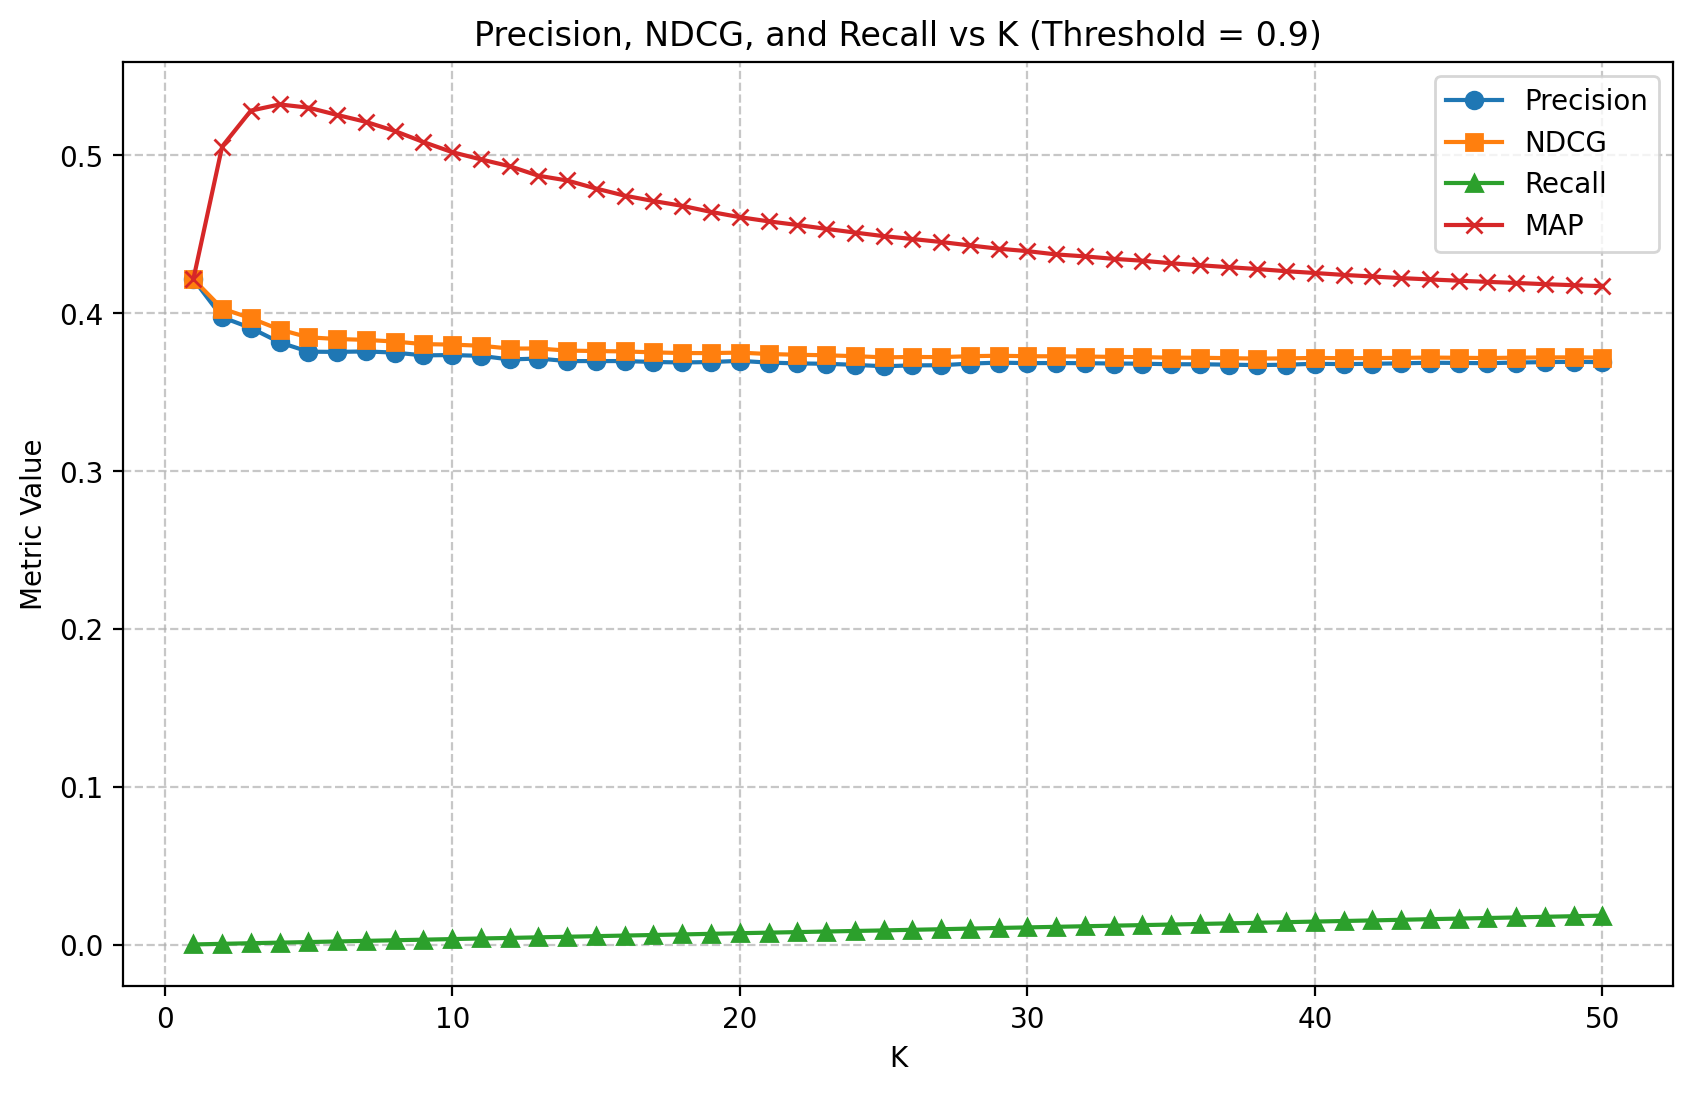

In [28]:
# Initialiser les listes pour stocker les résultats
ks = range(1, 51)
precisions = []
ndcgs = []
recalls = []
maps = []

# Calculer les métriques pour chaque valeur de k
for k in ks:
    print(f"Calculating metrics for k={k}...")
    evaluate = evaluate_implicit_at_k(predictions_pandas, k)   
    precisions.append(evaluate['precision'])
    ndcgs.append(evaluate['ndcg'])
    recalls.append(evaluate['recall'])
    maps.append(evaluate['map'])

# Tracer les résultats
plt.figure(figsize=(10, 6))
plt.plot(ks, precisions, label="Precision", marker='o')
plt.plot(ks, ndcgs, label="NDCG", marker='s')
plt.plot(ks, recalls, label="Recall", marker='^')
plt.plot(ks, maps, label="MAP", marker='x')
plt.title("Precision, NDCG, and Recall vs K (Threshold = 0.9)")
plt.xlabel("K")
plt.ylabel("Metric Value")
plt.legend()
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.show()

Calculating metrics for k=1...
Calculating metrics for k=2...
Calculating metrics for k=3...
Calculating metrics for k=4...
Calculating metrics for k=5...
Calculating metrics for k=6...
Calculating metrics for k=7...
Calculating metrics for k=8...
Calculating metrics for k=9...
Calculating metrics for k=10...
Calculating metrics for k=11...
Calculating metrics for k=12...
Calculating metrics for k=13...
Calculating metrics for k=14...
Calculating metrics for k=15...
Calculating metrics for k=16...
Calculating metrics for k=17...
Calculating metrics for k=18...
Calculating metrics for k=19...
Calculating metrics for k=20...
Calculating metrics for k=21...
Calculating metrics for k=22...
Calculating metrics for k=23...
Calculating metrics for k=24...
Calculating metrics for k=25...
Calculating metrics for k=26...
Calculating metrics for k=27...
Calculating metrics for k=28...
Calculating metrics for k=29...
Calculating metrics for k=30...
Calculating metrics for k=31...
Calculating metri

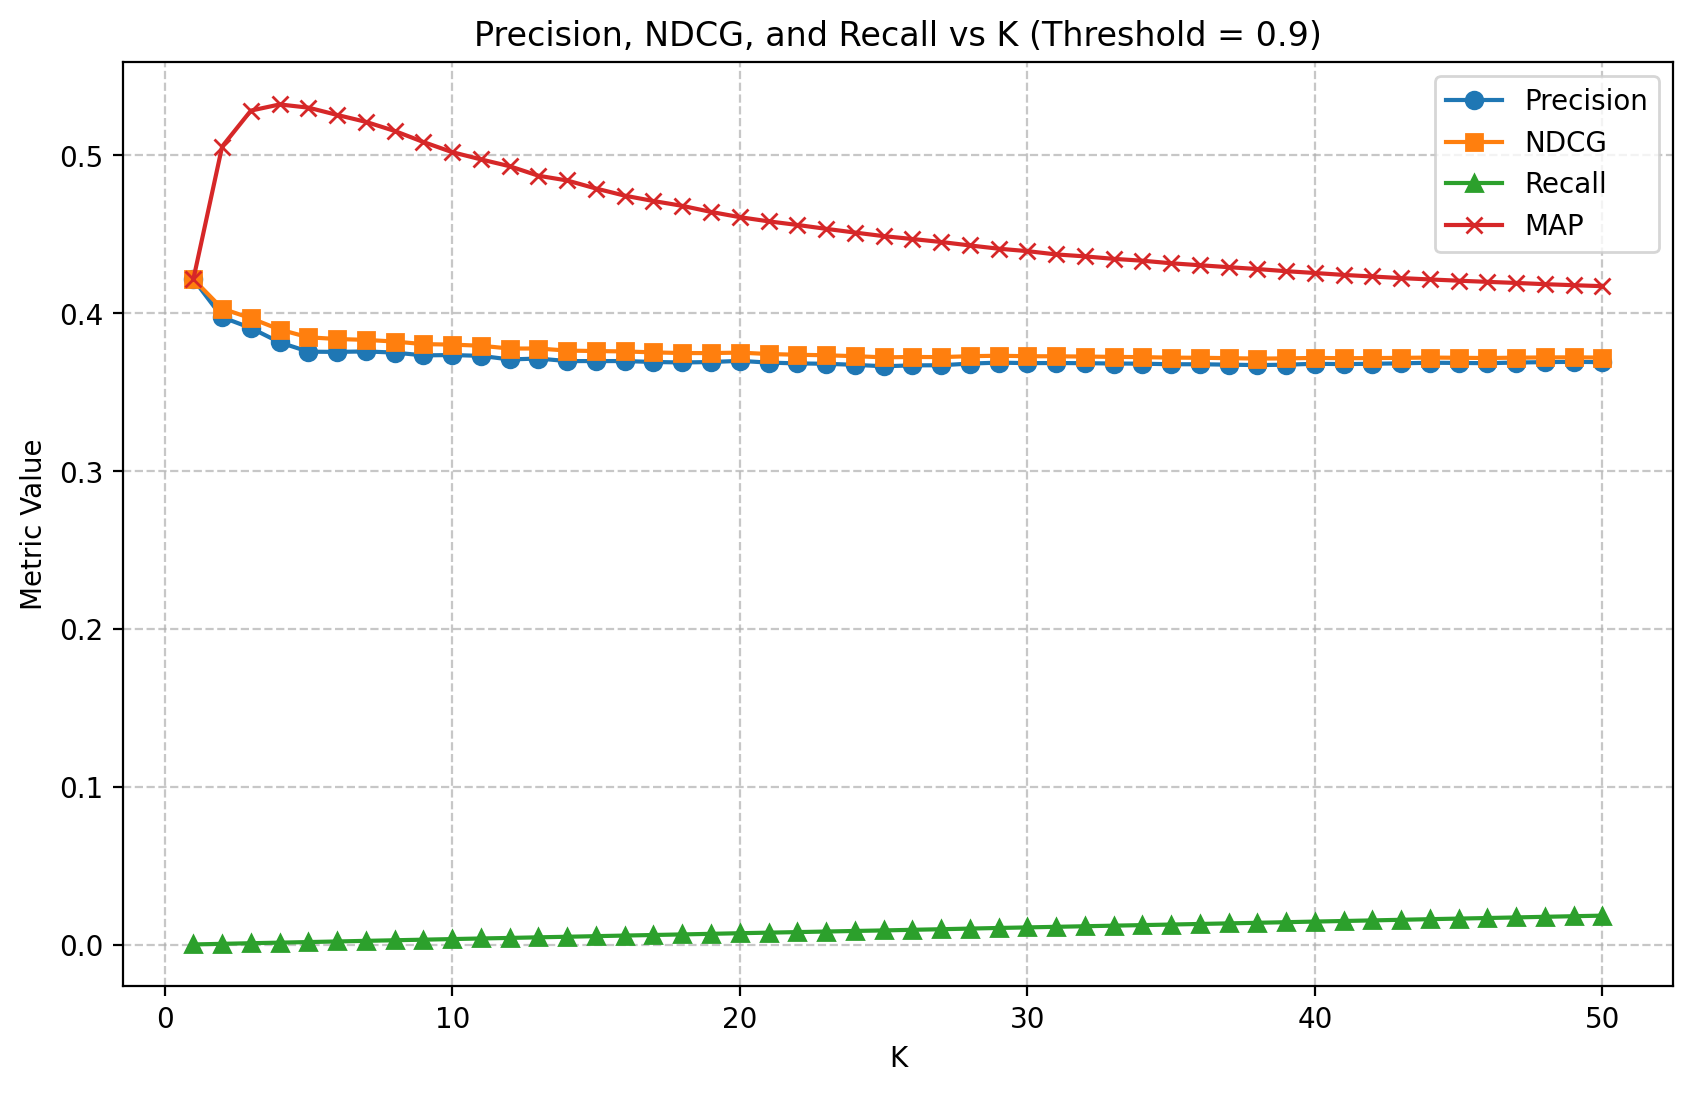

In [29]:
# Initialiser les listes pour stocker les résultats
ks = range(1, 51)
precisions = []
ndcgs = []
recalls = []
maps = []

# Calculer les métriques pour chaque valeur de k
for k in ks:
    print(f"Calculating metrics for k={k}...")
    evaluate = evaluate_implicit_at_k(predictions_pandas, k)   
    precisions.append(evaluate['precision'])
    ndcgs.append(evaluate['ndcg'])
    recalls.append(evaluate['recall'])
    maps.append(evaluate['map'])

# Tracer les résultats
plt.figure(figsize=(10, 6))
plt.plot(ks, precisions, label="Precision", marker='o')
plt.plot(ks, ndcgs, label="NDCG", marker='s')
plt.plot(ks, recalls, label="Recall", marker='^')
plt.plot(ks, maps, label="MAP", marker='x')
plt.title("Precision, NDCG, and Recall vs K (Threshold = 0.9)")
plt.xlabel("K")
plt.ylabel("Metric Value")
plt.legend()
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.show()